# Dataset

**Reading the dataset that is provided**

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
my_file = open('/content/drive/MyDrive/DSLab/database.txt')
data = my_file.read()

**Dividing the time series samples into different classes based on their first element of the data points**

In [53]:
from collections import defaultdict
sample_list = []
pointClassPairs = defaultdict(list)

samples = data.split("\n")
for sample in samples:
    sample_list.append(sample)

for idx in sample_list:
    dataPoints = idx.split(" ")
    cleaned_string = dataPoints[-1].strip()
    try:
        classValue = int(float(cleaned_string))
        dataPoints_list = dataPoints[:-1]
        dataPoints_val = [round(float(item), 4) for item in dataPoints_list]
        pointClassPairs[classValue].append(dataPoints_val)

    except ValueError:
        print("")

for i in pointClassPairs.keys():
    print(f"Class {i} has {len(pointClassPairs[i])} samples")

dataframe_list = []


Class 1 has 95 samples
Class 2 has 73 samples
Class 3 has 96 samples
Class 4 has 89 samples
Class 5 has 24 samples


**Defining the time series that is used for synthesizing and displaying two random time series samples from class 3 for the demonstration (to be used in paper)**

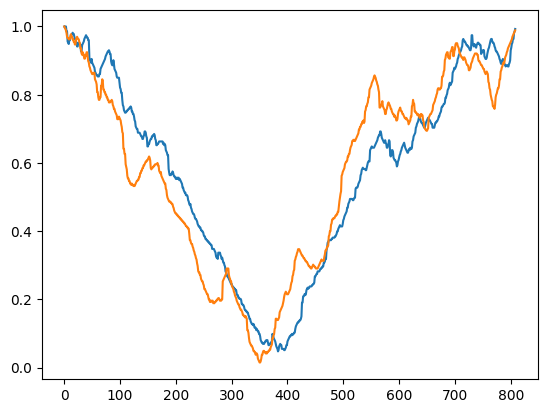

In [54]:
import arviz as az
import numpy
import matplotlib.pyplot as plt
arr = numpy.array(pointClassPairs[1][29])
arr2 = numpy.array(pointClassPairs[1][69])

test1 = numpy.array(pointClassPairs[3][3])
test2 = numpy.array(pointClassPairs[3][55])


plt.plot(test1)
plt.plot(test2)
plt.show()

**Plotting the Kernel Density Estimates**

<Axes: >

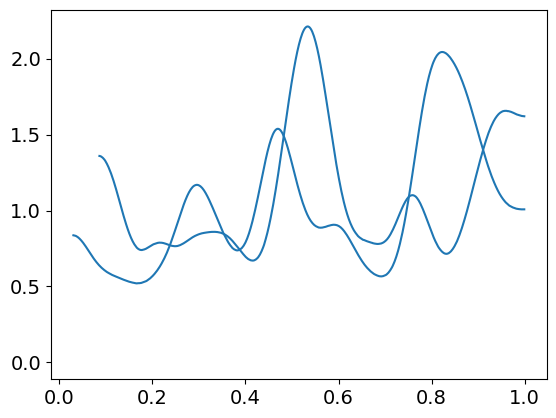

In [55]:
az.plot_kde(arr)
az.plot_kde(arr2)

**Finding the time series samples that has the same amount of data points. This is vital since our method requires two time series samples with exact same length in order to synthesized (or they should be normalized into same lenght)**

In [56]:
len_list = []

for index, val in enumerate(pointClassPairs[3]):
    len_list.append(len(pointClassPairs[3][index]))


In [57]:
from collections import Counter
from collections import defaultdict

# Create a dictionary to store indices of each element
index_dict = {}
for i, item in enumerate(len_list):
    if item in index_dict:
        index_dict[item].append(i)
    else:
        index_dict[item] = [i]

# Filter out elements with only one occurrence
repeating_elements = {k: v for k, v in index_dict.items() if len(v) > 1}

print(repeating_elements)

{815: [2, 44], 809: [3, 55], 1053: [13, 28], 859: [23, 91], 824: [26, 37], 947: [61, 74], 960: [65, 70]}


**Plotting five different time series samples from each class**

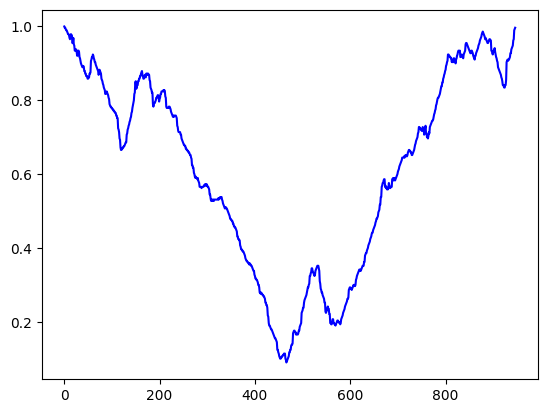

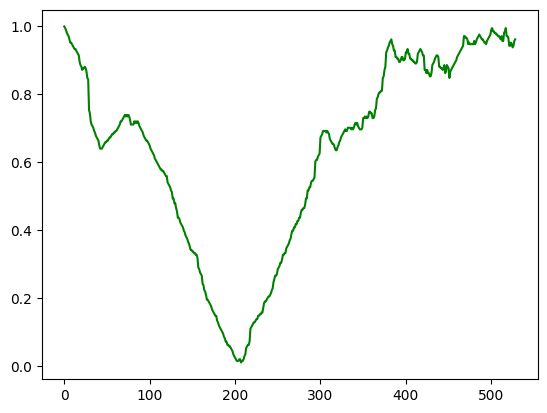

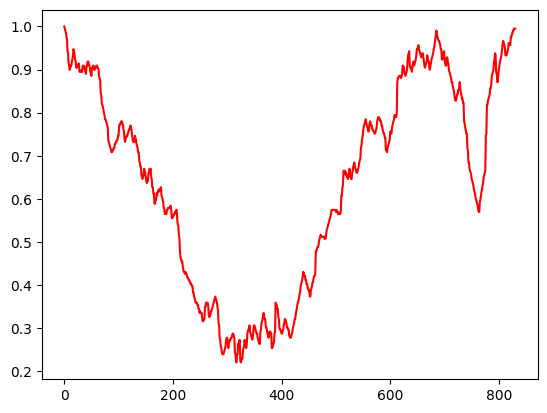

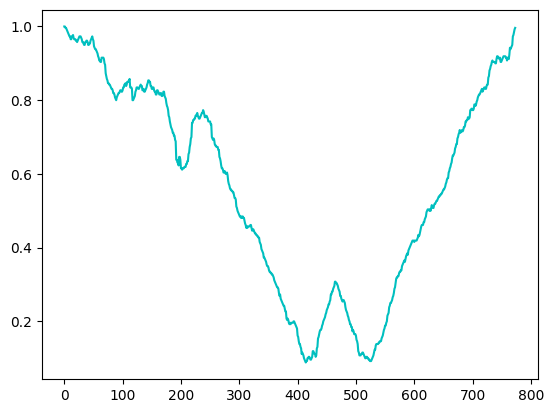

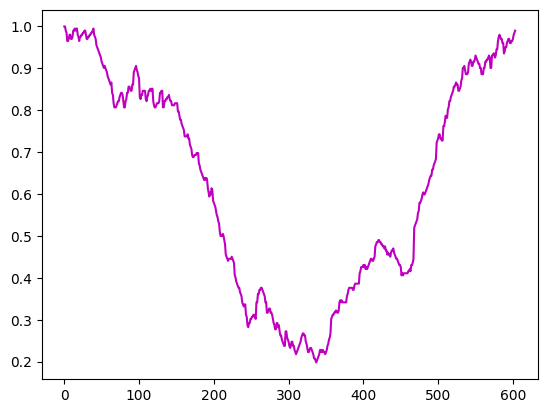

In [58]:
import random
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for i in range(5):
    plt.plot(pointClassPairs[i+1][random.randrange(1,24,1)], color=colors[i])
    plt.show()


**Visualizing the correlation between two time series samples that we are using for synthesizing**

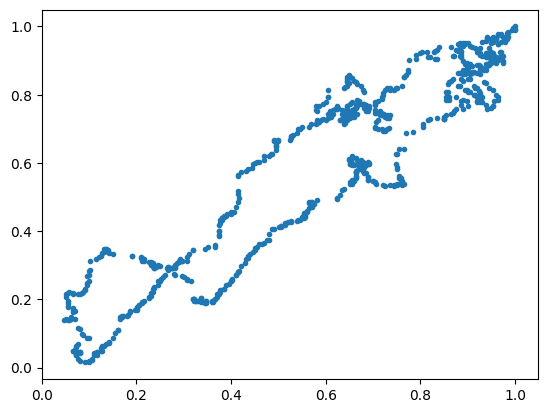

In [59]:
plt.plot(test1, test2, 'C0. ')
plt.show()

# Synthesizing time series

**Defining the Bayesian model with Gaussian distrubition with priors and finding the trace for posterior predicitive sampling**

## Preprocessing
**Original time series are normalized to a lenght in order to feed all the samples for data generation**

In [60]:
import numpy as np

def resample_time_series(data, target_length):
    """
    Resample each time series to have the same target length using interpolation.
    """
    resampled = []
    for ts in data:
        x_old = np.linspace(0, 1, len(ts))
        x_new = np.linspace(0, 1, target_length)
        resampled.append(np.interp(x_new, x_old, ts))
    return np.array(resampled)

# Determine the target length (e.g., shortest length or a specific fixed length)
target_length = min(len(ts) for ts in pointClassPairs[1])  # Use the shortest time series length
normalized_samples = resample_time_series(pointClassPairs[1], target_length)

In [61]:
# Generate the input (time indices) and output (observed values)
arr_input = np.tile(np.arange(target_length), (len(normalized_samples), 1))  # Time indices
arr_output = normalized_samples  # Observed time series values

## Modeling

In [62]:

import pymc as pm
import numpy as np

n_samples, n_timepoints = arr_output.shape

with pm.Model() as time_series_model:
    # Shared latent factor (captures common patterns across series)
    shared_trend = pm.Normal('shared_trend', mu=0, sigma=1, shape=n_timepoints)

    # Per-series scaling and offset
    a = pm.Normal('a', mu=0, sigma=1, shape=n_samples)  # Intercepts for each series
    b = pm.Normal('b', mu=1, sigma=0.5, shape=n_samples)  # Slopes for each series

    # Unique random walk for each time series (adds uniqueness)
    unique_trend = pm.GaussianRandomWalk('unique_trend', sigma=0.1, shape=(n_samples, n_timepoints))

    # Combine shared and unique patterns
    u = pm.Deterministic(
        'u',
        a[:, None] + b[:, None] * shared_trend + unique_trend
    )

    # Likelihood for the observed time series
    yPred = pm.Normal('yPred', mu=u, sigma=0.05, observed=arr_output)

    # Sampling the posterior
    trace = pm.sample(1, tune=500, chains=1, cores=1)

# Generate synthetic time series from the posterior predictive distribution
with time_series_model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['u'])


/usr/local/lib/python3.10/dist-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Output()

Output()

**Result**

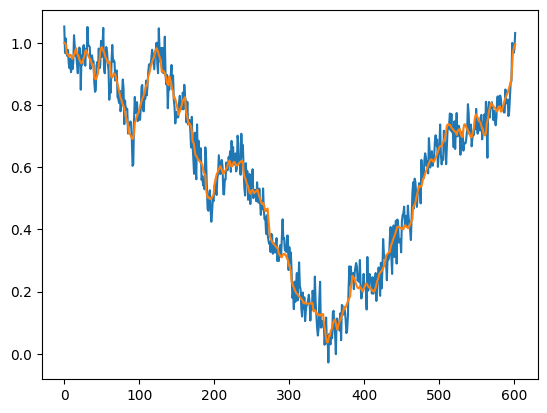

In [63]:

plt.plot(posterior_predictive['posterior_predictive']['u'][0][0][0])
plt.plot(arr_output[0])
plt.show()

**Different characteristics of generated time series**

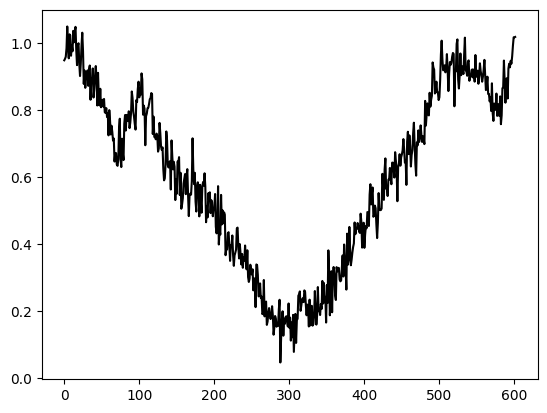

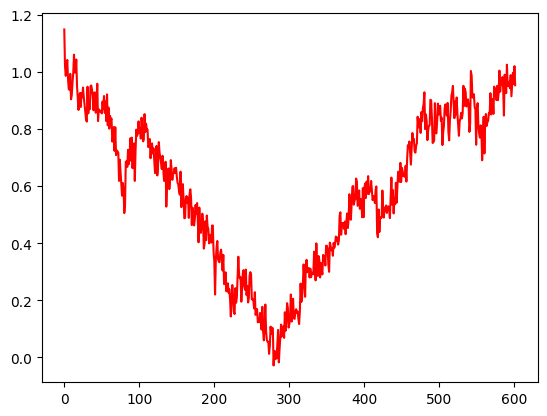

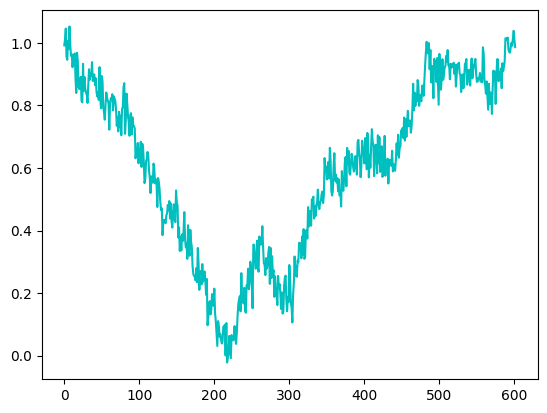

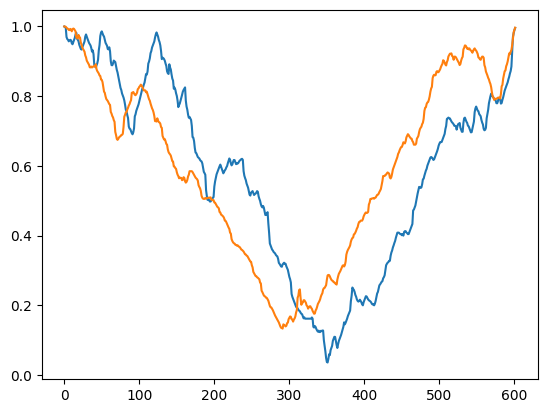

In [65]:
plt.plot(posterior_predictive['posterior_predictive']['u'][0][0][1], color=colors[6])
plt.show()

plt.plot(posterior_predictive['posterior_predictive']['u'][0][0][54], color=colors[2])
plt.show()

plt.plot(posterior_predictive['posterior_predictive']['u'][0][0][42], color=colors[3])
plt.show()

plt.plot(arr_output[0])
plt.plot(arr_output[1])
plt.show()

# Post Processing

## Moving Average

In [66]:
generated_series = posterior_predictive['posterior_predictive']['u'][0][0];

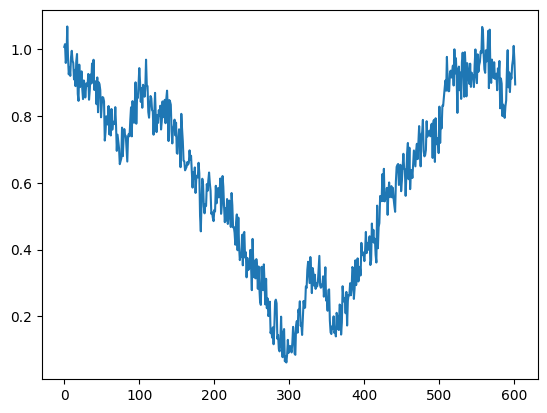

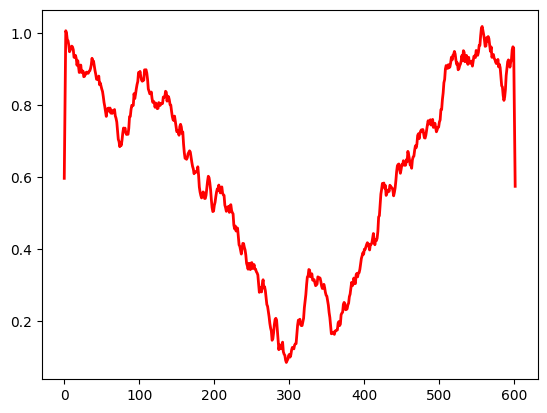

In [67]:
import numpy as np
import matplotlib.pyplot as plt

window_size = 5  # Choose a window size

# Moving average
moving_average_smoothed_series = np.convolve(generated_series[13], np.ones(window_size)/window_size, mode='same')

# Plot
plt.plot(generated_series[13], label="Original")
plt.show()
plt.plot(moving_average_smoothed_series, label="Smoothed (Moving Avg)", linewidth=2, color=colors[2])
plt.show()



## Exponential Moving Average (EMA)

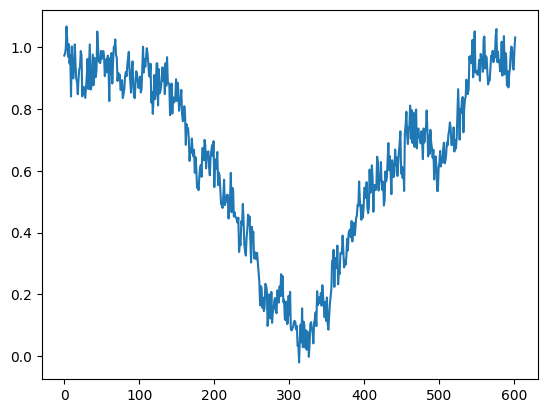

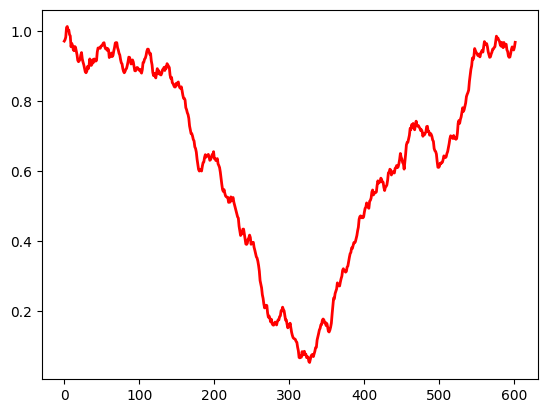

In [68]:
import pandas as pd

# Convert to pandas Series for EMA calculation
ema_generated_series = pd.Series(generated_series[60])

# Exponential moving average with a span of 10
ema_smoothed = ema_generated_series.ewm(span=10).mean()

# Plot
plt.plot(generated_series[60], label="Original")
plt.show()
plt.plot(ema_smoothed, label="Smoothed (EMA)", linewidth=2, color=colors[2])
plt.show()



## Savitzky-Golay Filter

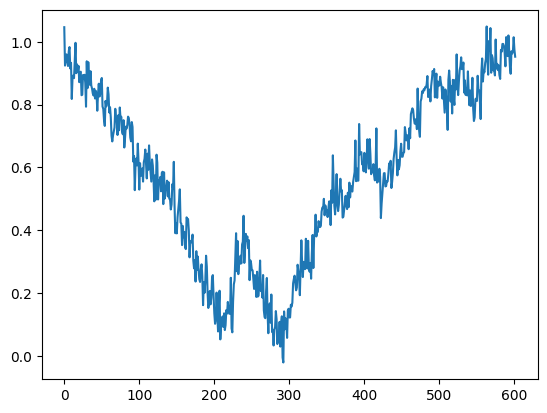

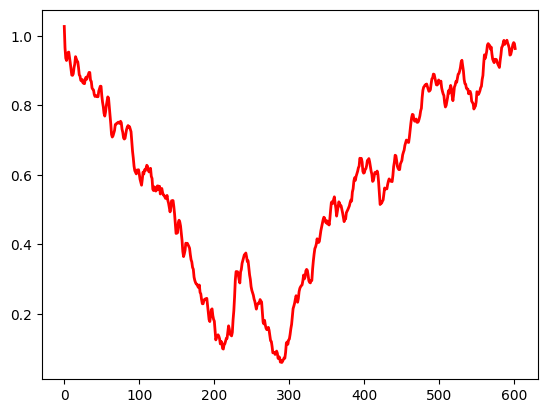

In [69]:
from scipy.signal import savgol_filter

# Savitzky-Golay filter
savitzky_smoothed_series = savgol_filter(generated_series, window_length=11, polyorder=3)  # Adjust window_length

# Plot
plt.plot(generated_series[76], label="Original")
plt.show()
plt.plot(savitzky_smoothed_series[76], label="Smoothed (Savitzky-Golay)", linewidth=2, color=colors[2])
plt.show()


## Wavelet Denoising

In [70]:
!pip install PyWavelets

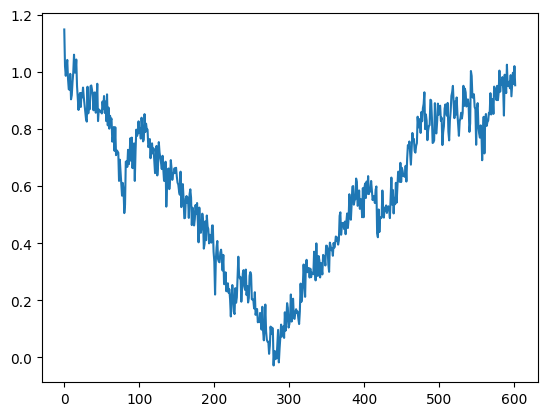

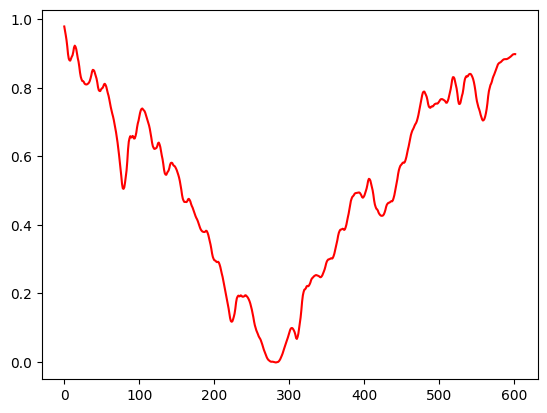

In [71]:
from statsmodels.robust import mad
import pywt
import pywt.data
gen_series = posterior_predictive['posterior_predictive']['u'][0][0]

def wavelet_denoise(series, wavelet='db4', level=3, threshold=0.2):
    # Decompose the series using Discrete Wavelet Transform
    coeffs = pywt.wavedec(series, wavelet, level=level)

    # Apply soft thresholding to suppress noise
    coeffs_denoised = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    # Reconstruct the denoised time series
    denoised_series = pywt.waverec(coeffs_denoised, wavelet)

    # Ensure output length matches input
    return denoised_series[:len(series)]

wavelet_series = [wavelet_denoise(series) for series in gen_series]

plt.plot(generated_series[54], label='Original')
plt.show()
plt.plot(wavelet_series[54], label='Smoothed', color = colors[2])
plt.show()

## Low-pass Filtering

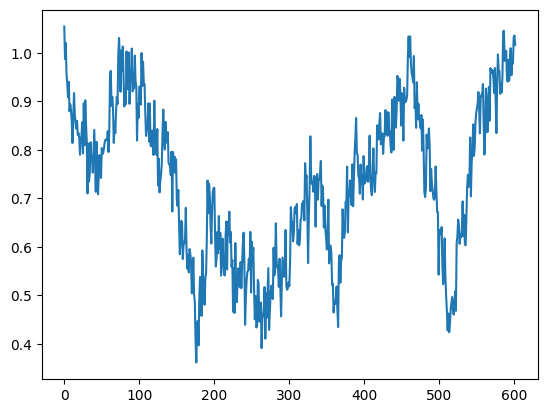

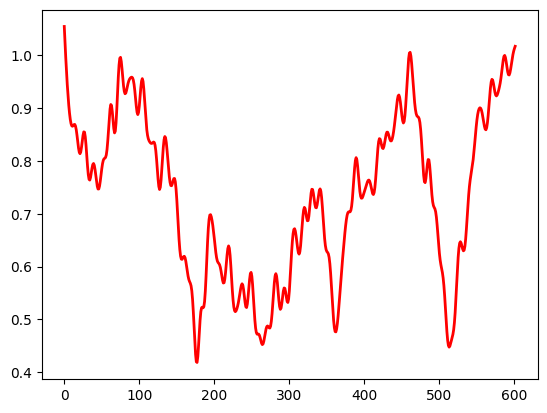

In [72]:
from scipy.signal import butter, filtfilt


# Design a low-pass Butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply the filter
cutoff = 0.1  # Cutoff frequency
fs = 1.0  # Sampling rate
lowpass_smoothed_series = butter_lowpass_filter(generated_series, cutoff, fs)

# Plot
plt.plot(generated_series[37], label="Original")
plt.show()
plt.plot(lowpass_smoothed_series[37], label="Smoothed (Low-pass Filter)", linewidth=2, color=colors[2])
plt.show()



# Evaluation Metrics


**Defining the evaluation metrics and comparing it between original to pseudo and original to original time series**

## Mean Absolute Error (MAE)

In [73]:
from sklearn.metrics import mean_absolute_error
import scipy.stats
from sklearn.metrics import mean_squared_error
from math import sqrt

mae = mean_absolute_error(arr_output[0], gen_series[0])
maeWave = mean_absolute_error(arr_output[0], wavelet_series[0])
maeMas = mean_absolute_error(arr_output[0], moving_average_smoothed_series)
maeEma = mean_absolute_error(arr_output[0], ema_smoothed)
maeSavitzky = mean_absolute_error(arr_output[0], savitzky_smoothed_series[0])
maeLowpass = mean_absolute_error(arr_output[0], lowpass_smoothed_series[0])
maeOrg = mean_absolute_error(arr_output[1], arr_output[2])

print(f'MAE of original and original: {maeOrg}')
print(f'MAE of original and generated: {mae}')
print(f'MAE of after Wavelet: {maeWave}')
print(f'MAE of after moving average smoothed: {maeMas}')
print(f'MAE of after EMA: {maeEma}')
print(f'MAE of after Savitzky: {maeSavitzky}')
print(f'MAE of after Low-pass Filtering: {maeLowpass}')

MAE of original and original: 0.05313925600190156
MAE of original and generated: 0.03433623021932859
MAE of after Wavelet: 0.06850704752666656
MAE of after moving average smoothed: 0.13200578651714662
MAE of after EMA: 0.11944874574432852
MAE of after Savitzky: 0.01917057113395447
MAE of after Low-pass Filtering: 0.018457616490929384


## Root Mean Squared Error(RMSE)

In [74]:
rmse = numpy.sqrt(mean_squared_error(arr_output[0], gen_series[0]))
rmsWave = numpy.sqrt(mean_squared_error(arr_output[0], wavelet_series[0]))
rmseMas = numpy.sqrt(mean_squared_error(arr_output[0], moving_average_smoothed_series))
rmseEma = numpy.sqrt(mean_squared_error(arr_output[0], ema_smoothed))
rmseSavitzky = numpy.sqrt(mean_squared_error(arr_output[0], savitzky_smoothed_series[0]))
rmseLowpass = numpy.sqrt(mean_squared_error(arr_output[0], lowpass_smoothed_series[0]))
rmseOrg = numpy.sqrt(mean_squared_error(arr_output[1], arr_output[2]))

print(f'RMSE of original and original: {rmseOrg}')
print(f'RMSE of original and generated: {rmse}')
print(f'RMSE of after Wavelet: {rmsWave}')
print(f'RMSE of after moving average smoothed: {rmseMas}')
print(f'RMSE of after EMA: {rmseEma}')
print(f'RMSE of after Savitzky: {rmseSavitzky}')
print(f'RMSE of after Low-pass Filtering: {rmseLowpass}')


RMSE of original and original: 0.06566763970856734
RMSE of original and generated: 0.04285817307586112
RMSE of after Wavelet: 0.07138006757617119
RMSE of after moving average smoothed: 0.15140846486783568
RMSE of after EMA: 0.14734892527143575
RMSE of after Savitzky: 0.024050683915762202
RMSE of after Low-pass Filtering: 0.022935288148583543


## Pearson Correlation

In [75]:
pearson_corr = numpy.corrcoef(arr_output[0], gen_series[0])[0, 1]
pearson_corr_wave = numpy.corrcoef(arr_output[0], wavelet_series[0])[0, 1]
pearson_corr_mas = numpy.corrcoef(arr_output[0], moving_average_smoothed_series)[0, 1]
pearson_corr_ema = numpy.corrcoef(arr_output[0], ema_smoothed)[0, 1]
pearson_corr_Savitzky = numpy.corrcoef(arr_output[0], savitzky_smoothed_series[0])[0, 1]
pearson_corr_Lowpass = numpy.corrcoef(arr_output[0], lowpass_smoothed_series[0])[0, 1]
pearson_corr_org = numpy.corrcoef(arr_output[1], arr_output[2])[0, 1]

print(f'Pearson Correlation of original and original: {pearson_corr_org}')
print(f'Pearson Correlation of original and generated: {pearson_corr}')
print(f'Pearson Correlation of after Wavelet: {pearson_corr_wave}')
print(f'Pearson Correlation of after moving average smoothed: {pearson_corr_mas}')
print(f'Pearson Correlation of after EMA: {pearson_corr_ema}')
print(f'Pearson Correlation of after Savitzky: {pearson_corr_Savitzky}')
print(f'Pearson Correlation of after Low-pass Filtering: {pearson_corr_Lowpass}')


Pearson Correlation of original and original: 0.9692844196274872
Pearson Correlation of original and generated: 0.9879190564628489
Pearson Correlation of after Wavelet: 0.9973184944869824
Pearson Correlation of after moving average smoothed: 0.8495725174814986
Pearson Correlation of after EMA: 0.8779468160880571
Pearson Correlation of after Savitzky: 0.9961691344160893
Pearson Correlation of after Low-pass Filtering: 0.9965208896222721


## Spearman Correlation

In [76]:
spearman_corr, _ = scipy.stats.spearmanr(arr_output[0], gen_series[0])
spearman_corr_wave, _ = scipy.stats.spearmanr(arr_output[0], wavelet_series[0])
spearman_corr_mas, _ = scipy.stats.spearmanr(arr_output[0], moving_average_smoothed_series)
spearman_corr_ema, _ = scipy.stats.spearmanr(arr_output[0], ema_smoothed)
spearman_corr_Savitzky, _ = scipy.stats.spearmanr(arr_output[0], savitzky_smoothed_series[0])
spearman_corr_Lowpass, _ = scipy.stats.spearmanr(arr_output[0], lowpass_smoothed_series[0])
spearman_corr_org, _ = scipy.stats.spearmanr(arr_output[1], arr_output[2])

print(f'Spearman Correlation of original and original: {spearman_corr_org}')
print(f'Spearman Correlation of original and generated: {spearman_corr}')
print(f'Spearman Correlation of after Wavelet: {spearman_corr_wave}')
print(f'Spearman Correlation of after moving average smoothed: {spearman_corr_mas}')
print(f'Spearman Correlation of after EMA: {spearman_corr_ema}')
print(f'Spearman Correlation of after Savitzky: {spearman_corr_Savitzky}')
print(f'Spearman Correlation of after Low-pass Filtering: {spearman_corr_Lowpass}')

Spearman Correlation of original and original: 0.9684524946852607
Spearman Correlation of original and generated: 0.9857831650285246
Spearman Correlation of after Wavelet: 0.996130154413051
Spearman Correlation of after moving average smoothed: 0.8286031591858017
Spearman Correlation of after EMA: 0.8859850062228767
Spearman Correlation of after Savitzky: 0.9951162112228262
Spearman Correlation of after Low-pass Filtering: 0.9955039892140969


## SQL (Scaled Quantile Loss)



In [77]:
def scaled_quantile_loss(y_true, y_pred, quantile):
    numerator = np.sum((y_true - y_pred) * (quantile - (y_true < y_pred)))
    denominator = np.sum(np.abs(y_true))
    return 2 * numerator / denominator

# Example usage:
quantile = 0.5  # 50th percentile (median)
sql = scaled_quantile_loss(arr_output[0], gen_series[0], quantile)
sql_wave = scaled_quantile_loss(arr_output[0], wavelet_series[0], quantile)
sql_mas = scaled_quantile_loss(arr_output[0], moving_average_smoothed_series, quantile)
sql_ema = scaled_quantile_loss(arr_output[0], ema_smoothed, quantile)
sql_Sav = scaled_quantile_loss(arr_output[0], savitzky_smoothed_series[0], quantile)
sql_Lowpass = scaled_quantile_loss(arr_output[0], lowpass_smoothed_series[0], quantile)
sql_org = scaled_quantile_loss(arr_output[1], arr_output[2], quantile)

quantiles = [0.1, 0.5, 0.9]
for q in quantiles:
    sql = scaled_quantile_loss(arr_output[0], gen_series[0], q)
    print(f'SQL of original and generated for quantile {q}: {sql}')

    sql_wave = scaled_quantile_loss(arr_output[0], wavelet_series[0], q)
    sql_mas = scaled_quantile_loss(arr_output[0], moving_average_smoothed_series, q)
    sql_ema = scaled_quantile_loss(arr_output[0], ema_smoothed, q)
    sql_Sav = scaled_quantile_loss(arr_output[0], savitzky_smoothed_series[0], q)
    sql_Lowpass = scaled_quantile_loss(arr_output[0], lowpass_smoothed_series[0], q)
    sql_org = scaled_quantile_loss(arr_output[1], arr_output[2], q)


    print(f'SQL of after original to original for quantile {q}: {sql_org}')
    print(f'SQL of after Wavelet for quantile {q}: {sql_wave}')
    print(f'SQL of after moving average smoothed for quantile {q}: {sql_mas}')
    print(f'SQL of after EMA for quantile {q}: {sql_ema}')
    print(f'SQL of after Savitzky for quantile {q}: {sql_Sav}')
    print(f'SQL of after Low-pass Filtering for quantile {q}: {sql_Lowpass}')


SQL of original and generated for quantile 0.1: <xarray.DataArray 'u' ()> Size: 8B
array(0.06160138)
Coordinates:
    chain    int64 8B 0
    draw     int64 8B 0
    u_dim_2  int64 8B 0
SQL of after original to original for quantile 0.1: 0.07093918008610514
SQL of after Wavelet for quantile 0.1: 0.023536614228611055
SQL of after moving average smoothed for quantile 0.1: 0.27038916462922025
SQL of after EMA for quantile 0.1: 0.27425319427258615
SQL of after Savitzky for quantile 0.1: 0.03558523627014974
SQL of after Low-pass Filtering for quantile 0.1: 0.03445574196654821
SQL of original and generated for quantile 0.5: <xarray.DataArray 'u' ()> Size: 8B
array(0.05898361)
Coordinates:
    chain    int64 8B 0
    draw     int64 8B 0
    u_dim_2  int64 8B 0
SQL of after original to original for quantile 0.5: 0.08848339012398752
SQL of after Wavelet for quantile 0.5: 0.11768307114305529
SQL of after moving average smoothed for quantile 0.5: 0.22676274816755682
SQL of after EMA for quantile 

## Dynamic Time Warping (DTW)

In [78]:
!pip install fastdtw

In [79]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Extract values from DataArray objects to NumPy array
y_true = np.array(arr_output[0], dtype=float).ravel()
y_pred = np.array([item.values if hasattr(item, 'values') else item for item in gen_series[0]], dtype=float)

# Postprocessed series
y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()

y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()

# Function to compute DTW distance
def compute_dtw(y_true, y_pred):
    # Remove NaNs and Infs, ensure memory is contiguous
    y_true = np.nan_to_num(y_true)
    y_pred = np.nan_to_num(y_pred)
    y_true = np.ascontiguousarray(y_true)
    y_pred = np.ascontiguousarray(y_pred)

    # Compute DTW distance using squared Euclidean distance
    distance, _ = fastdtw(y_true, y_pred, dist=lambda x, y: (x - y) ** 2)
    return distance

# Compute DTW for each case
dtw_original = compute_dtw(y_true, y_pred)
dtw_wavelet = compute_dtw(y_true, y_wavelet)
dtw_moving_avg = compute_dtw(y_true, y_moving_avg)
dtw_ema = compute_dtw(y_true, y_ema)
dtw_savitzky = compute_dtw(y_true, y_savitzky)
dtw_lowpass = compute_dtw(y_true, y_lowpass)
data_org = compute_dtw(y_org, y_org2)

# Print results
print(f'DTW Distance (Original): {dtw_original}')
print(f'DTW Distance (Synthetic): {data_org}')
print(f'DTW Distance (Wavelet Denoised): {dtw_wavelet}')
print(f'DTW Distance (Moving Average Smoothed): {dtw_moving_avg}')
print(f'DTW Distance (Exponential Moving Average): {dtw_ema}')
print(f'DTW Distance (Savitzky-Golay Filter): {dtw_savitzky}')
print(f'DTW Distance (Low-pass Filter): {dtw_lowpass}')


DTW Distance (Original): 0.7407966435937751
DTW Distance (Synthetic): 0.36462433889493656
DTW Distance (Wavelet Denoised): 0.3338393057371189
DTW Distance (Moving Average Smoothed): 0.8382747721576465
DTW Distance (Exponential Moving Average): 0.7362875193734661
DTW Distance (Savitzky-Golay Filter): 0.07998951452789448
DTW Distance (Low-pass Filter): 0.07230699791652258


## Time-Weighted Dynamic Time Warping (TDTW)

In [80]:
import numpy as np
from fastdtw import fastdtw

def time_weight(t, length, mode='linear'):
    if mode == 'linear':
        return 1 - (t / length)
    elif mode == 'exponential':
        return np.exp(-t / length)
    elif mode == 'custom':
        return np.sin((t / length) * np.pi)
    else:
        raise ValueError(f"Unknown mode: {mode}")

def weighted_distance(x, y, t, length, mode='linear'):
    weight = time_weight(t, length, mode)
    return weight * np.abs(x - y)  # Absolute difference (like L1 distance)

def time_weighted_dtw(y_true, y_pred, mode='linear'):
    length = len(y_true)
    distance, path = fastdtw(
        y_true,
        y_pred,
        dist=lambda x, y: weighted_distance(x, y, t=min(x, y), length=length, mode=mode)
    )
    return distance, path

# Example Usage for Postprocessed Series
y_true = np.array(arr_output[0], dtype=float).ravel()

# Postprocessed series
y_pred = np.array([item.values if hasattr(item, 'values') else item for item in gen_series[0]], dtype=float)
y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()
y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()

# Compute TDTW distances
tdtw_original, _ = time_weighted_dtw(y_true, y_pred, mode='linear')
tdtw_wavelet, _ = time_weighted_dtw(y_true, y_wavelet, mode='linear')
tdtw_moving_avg, _ = time_weighted_dtw(y_true, y_moving_avg, mode='linear')
tdtw_ema, _ = time_weighted_dtw(y_true, y_ema, mode='linear')
tdtw_savitzky, _ = time_weighted_dtw(y_true, y_savitzky, mode='linear')
tdtw_lowpass, _ = time_weighted_dtw(y_true, y_lowpass, mode='linear')
tdtw_org, _ = time_weighted_dtw(y_org, y_org2, mode='linear')

# Print Results
print(f'TDTW Distance (Original): {tdtw_org}')
print(f'TDTW Distance (Synthetic): {tdtw_original}')
print(f'TDTW Distance (Wavelet Denoised): {tdtw_wavelet}')
print(f'TDTW Distance (Moving Average Smoothed): {tdtw_moving_avg}')
print(f'TDTW Distance (Exponential Moving Average): {tdtw_ema}')
print(f'TDTW Distance (Savitzky-Golay Filter): {tdtw_savitzky}')
print(f'TDTW Distance (Low-pass Filter): {tdtw_lowpass}')


TDTW Distance (Original): 10.038682218975715
TDTW Distance (Synthetic): 17.484492647147036
TDTW Distance (Wavelet Denoised): 11.392568826967754
TDTW Distance (Moving Average Smoothed): 12.746871792074824
TDTW Distance (Exponential Moving Average): 12.832991168821689
TDTW Distance (Savitzky-Golay Filter): 5.978267009225472
TDTW Distance (Low-pass Filter): 5.248401124725729


## Hausdorff Distance

In [81]:
!pip install frechetdist

In [82]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

# Define a function to calculate Hausdorff Distance
def compute_hausdorff(y_true, y_pred):
    # Reshape both series to 2D arrays for Hausdorff calculation
    return directed_hausdorff(y_true.reshape(-1, 1), y_pred.reshape(-1, 1))[0]

# Extract values from DataArray objects to NumPy arrays
y_true = np.array(arr_output[0], dtype=float).ravel()

# Postprocessed series
y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()
y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()

# Compute Hausdorff distance for each case
hausdorff_original = compute_hausdorff(y_true, y_pred)
hausdorff_wavelet = compute_hausdorff(y_true, y_wavelet)
hausdorff_moving_avg = compute_hausdorff(y_true, y_moving_avg)
hausdorff_ema = compute_hausdorff(y_true, y_ema)
hausdorff_savitzky = compute_hausdorff(y_true, y_savitzky)
hausdorff_lowpass = compute_hausdorff(y_true, y_lowpass)
hausdorff_org = compute_hausdorff(y_org, y_org2)

# Print results
print(f'Hausdorff Distance (Original): {hausdorff_org}')
print(f'Hausdorff Distance (Synthetic): {hausdorff_original}')
print(f'Hausdorff Distance (Wavelet Denoised): {hausdorff_wavelet}')
print(f'Hausdorff Distance (Moving Average Smoothed): {hausdorff_moving_avg}')
print(f'Hausdorff Distance (Exponential Moving Average): {hausdorff_ema}')
print(f'Hausdorff Distance (Savitzky-Golay Filter): {hausdorff_savitzky}')
print(f'Hausdorff Distance (Low-pass Filter): {hausdorff_lowpass}')


Hausdorff Distance (Original): 0.00843477537437487
Hausdorff Distance (Synthetic): 0.004578398107109194
Hausdorff Distance (Wavelet Denoised): 0.06470800959360123
Hausdorff Distance (Moving Average Smoothed): 0.048707218001273485
Hausdorff Distance (Exponential Moving Average): 0.01608677324697899
Hausdorff Distance (Savitzky-Golay Filter): 0.00627404073598381
Hausdorff Distance (Low-pass Filter): 0.005549452976202129


## Fretchet Distance

In [83]:
import numpy as np
from frechetdist import frdist

# Function to compute Fréchet Distance
def compute_frechet(y_true, y_pred):
    # Convert to 2D curves [(t, y1), (t, y2), ...]
    p = [(t, y) for t, y in enumerate(y_true)]
    q = [(t, y) for t, y in enumerate(y_pred)]
    return frdist(p, q)

# Extract values from DataArray objects to NumPy arrays
y_true = np.array(arr_output[0], dtype=float).ravel()

# Postprocessed series
y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()
y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()

# Compute Fréchet distance for each case
frechet_original = compute_frechet(y_true, y_pred)
frechet_wavelet = compute_frechet(y_true, y_wavelet)
frechet_moving_avg = compute_frechet(y_true, y_moving_avg)
frechet_ema = compute_frechet(y_true, y_ema)
frechet_savitzky = compute_frechet(y_true, y_savitzky)
frechet_lowpass = compute_frechet(y_true, y_lowpass)
frechet_org = compute_frechet(y_org, y_org2)

# Print results
print(f'Fréchet Distance (Original): {frechet_org}')
print(f'Fréchet Distance (Synthetic): {frechet_original}')
print(f'Fréchet Distance (Wavelet Denoised): {frechet_wavelet}')
print(f'Fréchet Distance (Moving Average Smoothed): {frechet_moving_avg}')
print(f'Fréchet Distance (Exponential Moving Average): {frechet_ema}')
print(f'Fréchet Distance (Savitzky-Golay Filter): {frechet_savitzky}')
print(f'Fréchet Distance (Low-pass Filter): {frechet_lowpass}')


Fréchet Distance (Original): 0.1882
Fréchet Distance (Synthetic): 0.12327431125587351
Fréchet Distance (Wavelet Denoised): 0.15075198406348067
Fréchet Distance (Moving Average Smoothed): 0.4218597686263976
Fréchet Distance (Exponential Moving Average): 0.3436577724516512
Fréchet Distance (Savitzky-Golay Filter): 0.08274907785286917
Fréchet Distance (Low-pass Filter): 0.081435681311185


## Cross-Correlation Function (CCF)

In [84]:
!pip install statsmodels

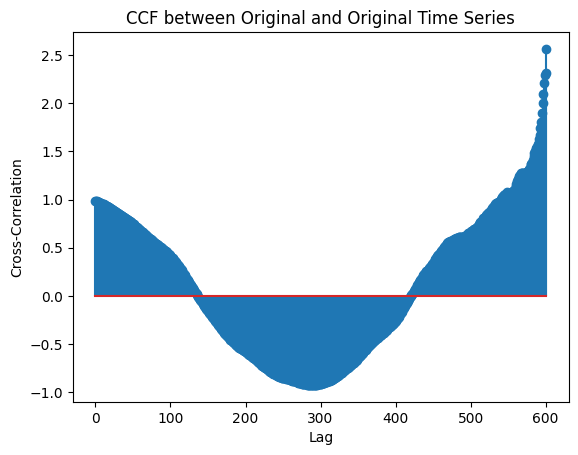

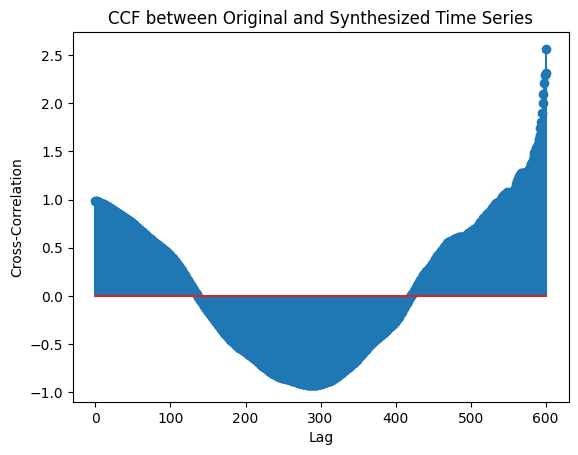

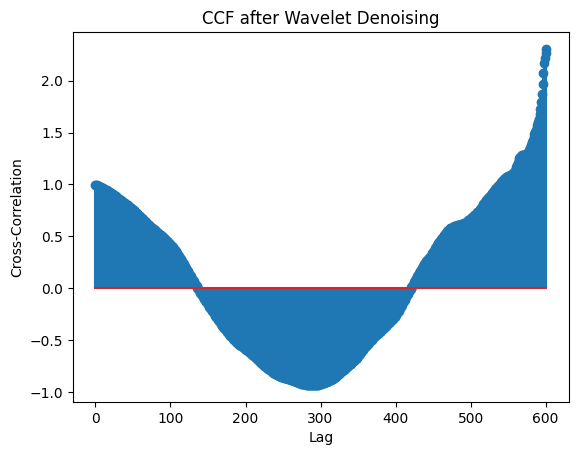

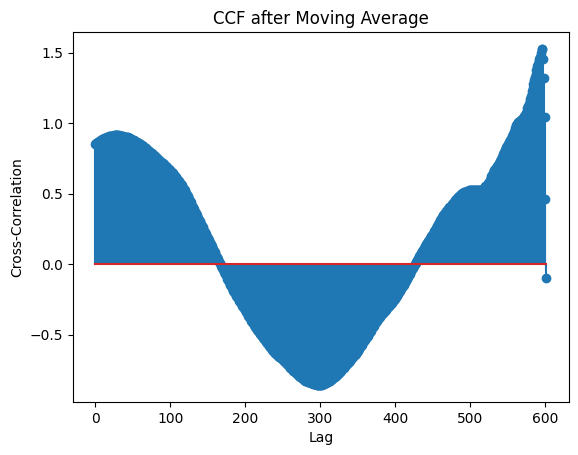

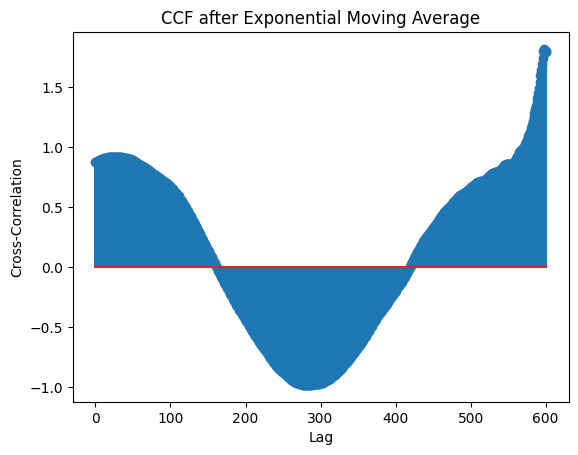

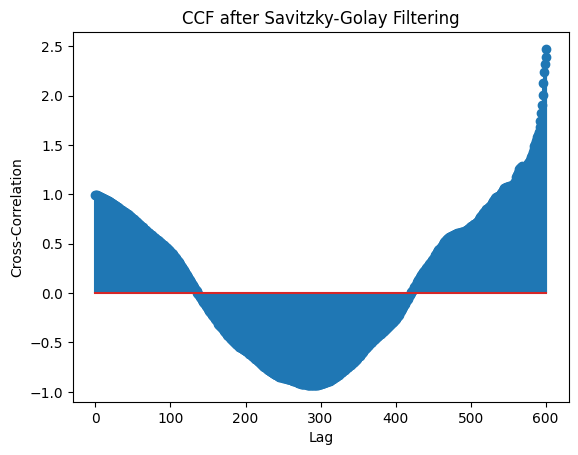

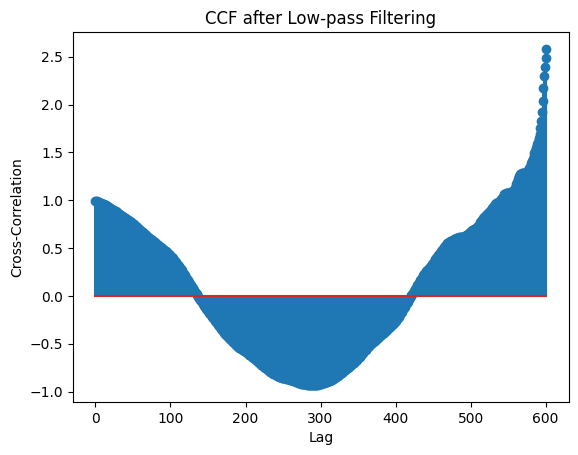

array([ 0.99652089,  0.99363413,  0.99018054,  0.98625112,  0.98224786,
        0.97814385,  0.9740764 ,  0.97019668,  0.96649239,  0.9629566 ,
        0.95955765,  0.95628689,  0.95299369,  0.94951265,  0.94579413,
        0.94180029,  0.93747278,  0.93282929,  0.92811348,  0.92317651,
        0.91805167,  0.91286304,  0.90765074,  0.9025116 ,  0.89749052,
        0.89254207,  0.88765703,  0.88277783,  0.87781299,  0.87256506,
        0.86704914,  0.86137441,  0.8555529 ,  0.84964865,  0.84374716,
        0.83791204,  0.83219644,  0.82666889,  0.82135424,  0.81605081,
        0.81088377,  0.80604403,  0.8012083 ,  0.79633731,  0.79131853,
        0.78612994,  0.78071306,  0.77483831,  0.7686228 ,  0.76192554,
        0.75493993,  0.74776908,  0.74057211,  0.73341058,  0.72631804,
        0.71939389,  0.71266027,  0.70602134,  0.69940388,  0.69277772,
        0.68595153,  0.67878748,  0.6714805 ,  0.66430521,  0.65716381,
        0.65004256,  0.64297814,  0.63598708,  0.6292106 ,  0.62

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# Convert time series to 1D arrays
y_true = np.array(arr_output[0], dtype=float).ravel()

# Postprocessed series
y_pred = np.array([item.values if hasattr(item, 'values') else item for item in gen_series[0]], dtype=float)
y_wavelet = np.array(wavelet_series[0], dtype=float).ravel()
y_moving_avg = np.array(moving_average_smoothed_series, dtype=float).ravel()
y_ema = np.array(ema_smoothed, dtype=float).ravel()
y_savitzky = np.array(savitzky_smoothed_series[0], dtype=float).ravel()
y_lowpass = np.array(lowpass_smoothed_series[0], dtype=float).ravel()
y_org = np.array(arr_output[1], dtype=float).ravel()
y_org2 = np.array(arr_output[2], dtype=float).ravel()

# Function to compute and plot CCF for a given series
def compute_ccf(y_true, y_pred, title="Cross-Correlation Function (CCF)"):
    cross_corr = ccf(y_true, y_pred)

    # Plot the CCF without 'use_line_collection'
    plt.stem(cross_corr)
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.title(title)
    plt.show()
    return cross_corr

# Compute and plot CCF for each series
compute_ccf(y_true, y_pred, title="CCF between Original and Original Time Series")
compute_ccf(y_true, y_pred, title="CCF between Original and Synthesized Time Series")
compute_ccf(y_true, y_wavelet, title="CCF after Wavelet Denoising")
compute_ccf(y_true, y_moving_avg, title="CCF after Moving Average")
compute_ccf(y_true, y_ema, title="CCF after Exponential Moving Average")
compute_ccf(y_true, y_savitzky, title="CCF after Savitzky-Golay Filtering")
compute_ccf(y_true, y_lowpass, title="CCF after Low-pass Filtering")
